# RNN Model For Classifying Tweets

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.legacy.data import Field, TabularDataset, BucketIterator


import train_test_datasets as pdata
from lstm import LSTM
from evaluate import train_model, evaluate, load_checkpoint


In [5]:
# parameters
DATA_PATH = './data/tweets_all.csv'
SAVE_PATH = './data'

TEST_VALID_PERC=0.2
BATCH_SIZE = 32
MAX_SEQ_LEN = 150
BPTT_LENGTH = 64

EPOCHS = 5
LOSS_FN = nn.CrossEntropyLoss
OPTIM_FN = optim.Adam
HIDDEN_DIM = 150
LEARN_RATE = 0.001
DROP_OUT = 0.5
LAYERS = 2

In [6]:
# test and set kernel device
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")

Using cpu.


In [7]:
class_weights = pdata.make_data(DATA_PATH, SAVE_PATH, TEST_VALID_PERC)

# adding weights to loss function
class_weights.to(DEVICE)
LOSS_FN = LOSS_FN(weight=class_weights)

Datasets saved.
./data/train.csv saved; 12914 records
./data/valid.csv saved; 1436 records
./data/test.csv saved; 1596 records

checking class balance:
low in train:  4699
high in train:  8215


In [8]:
# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset
train, valid, test = TabularDataset.splits(path=SAVE_PATH, 
                                           train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators
train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=DEVICE, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=DEVICE, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=DEVICE, sort=True, sort_within_batch=True)

# Vocabulary
text_field.build_vocab(train, min_freq=3)
print("vocab length: ", len(text_field.vocab))

vocab length:  8551


In [9]:
model = LSTM(vocab_len=len(text_field.vocab),
             dropout=DROP_OUT,
             dimension=HIDDEN_DIM,
             layers=LAYERS).to(DEVICE)

optimizer = OPTIM_FN(model.parameters(), lr=LEARN_RATE)

train_model(model=model,
            optimizer=optimizer,
            train_loader=train_iter,
            valid_loader=valid_iter,
            criterion = LOSS_FN,
            num_epochs = EPOCHS,
            file_path = SAVE_PATH,
            device=DEVICE)

Epoch [1/2], Step [147/588], Train Loss: 0.7216, Valid Loss: 0.6762
Model saved to ==> ./data/model.pt
Model saved to ==> ./data/metrics.pt
Epoch [1/2], Step [294/588], Train Loss: 0.6499, Valid Loss: 0.6910
Epoch [2/2], Step [441/588], Train Loss: 0.6586, Valid Loss: 0.6402
Model saved to ==> ./data/model.pt
Model saved to ==> ./data/metrics.pt
Epoch [2/2], Step [588/588], Train Loss: 0.5644, Valid Loss: 0.6611
Model saved to ==> ./data/metrics.pt
Finished Training!


Model loaded from <== ./data/model.pt
Test Accuracy:  0.6086206896551725
Classification Report:
              precision    recall  f1-score   support

           1     0.6289    0.5268    0.5733       579
           0     0.5941    0.6902    0.6385       581

    accuracy                         0.6086      1160
   macro avg     0.6115    0.6085    0.6059      1160
weighted avg     0.6114    0.6086    0.6060      1160



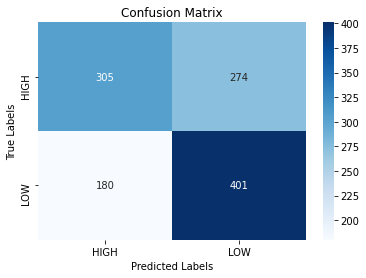

In [7]:
# Evaluate
best_model = LSTM(vocab_len=len(text_field.vocab),
                  dropout=DROP_OUT,
                  dimension=HIDDEN_DIM,
                  layers=LAYERS).to(DEVICE)

optimizer = OPTIM_FN(best_model.parameters(), lr=0.001)

load_checkpoint(SAVE_PATH + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

## Feature importance

### Integrated gradient

In [8]:
from captum.attr import IntegratedGradients, LayerIntegratedGradients, TokenReferenceBase, visualization
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

In [9]:
device = torch.device("cpu")
test = pd.read_csv('data/test.csv')
PAD_IDX = text_field.vocab.stoi['<pad>']
token_reference = TokenReferenceBase(reference_token_idx=PAD_IDX)

In [10]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def int_gradient(text, max_len, true_label=0, target_label=0):
    print(text)
    words = tokenizer(text)
    if len(words) < max_len:
        words += ['<pad>'] * (max_len - len(words))
    tokens = [text_field.vocab.stoi[w] for w in words]
    #print(tokens)
    
    best_model.zero_grad()
    input_indices = torch.tensor(tokens)
    input_indices = input_indices.unsqueeze(0)
    #print('input:', input_indices)
    
    # predict
    probs = best_model(input_indices, torch.tensor([max_len]))
    pred = torch.argmax(probs).item()
    pred_prob = probs.tolist()[0][pred]
    #print(probs)
    
    forward_func = lambda x: F.softmax(best_model(x,torch.tensor([max_len])), dim=-1)
    lig = LayerIntegratedGradients(forward_func, best_model.embedding)
    
    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(max_len, device=device).unsqueeze(0)
    #print(reference_indices)
    
    
    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=500, target=target_label, return_convergence_delta=True)
    
    print('pred: ', pred, '(', '%.2f'%pred_prob, ')', ', delta: ', abs(delta.tolist()[0]))    
    
    add_attributions_to_visualizer(attributions_ig, words, pred_prob, pred, true_label, delta, target_label, vis_data_records_ig)
    
    #return attributions_ig

def add_attributions_to_visualizer(attributions, text, pred_prob, pred, label, delta, target, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()
    true_label = 'High' if int(label) == 1 else 'Low'
    pred_label = 'High' if int(pred) == 1 else 'Low'
    target_label = 'High' if int(target) == 1 else 'Low'
    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred_prob,
                            pred_label,
                            true_label,
                            target_label,
                            attributions.sum(),       
                            text,
                            delta))


In [11]:
int_gradient(test['text'][0], len(tokenizer(test['text'][0])), test['label'][0])
int_gradient(test['text'][100], len(tokenizer(test['text'][100])), test['label'][100])
int_gradient(test['text'][506], len(tokenizer(test['text'][506])), test['label'][506])
int_gradient(test['text'][1156], len(tokenizer(test['text'][1156])), test['label'][1156])
int_gradient(test['text'][1157], len(tokenizer(test['text'][1157])), test['label'][1157])
int_gradient(test['text'][1158], len(tokenizer(test['text'][1157])), test['label'][1158])

beijing was shrouded in thick brown dust due to strong winds blowing in from the gobi desert and parts of northwestern china in what the weather bureau called the biggest sandstorm in a decade
pred:  0 ( 0.83 ) , delta:  0.03042054620757147
elsa peretti the jewelry designer whose elegant sculptural creations for tiffany amp company redefined tastes in accessories has died at
pred:  0 ( 0.62 ) , delta:  0.1299184519578859
tugs dredgers still struggle to free ship blocking suez canal
pred:  0 ( 0.89 ) , delta:  0.004879267419235395
colorado rep boebert decries senseless violence in boulder
pred:  1 ( 0.63 ) , delta:  0.2545550222480457
the oscar contender promising young woman is a dark revenge fantasy that raises deep questions about sexual assault and justice co hosts and discuss what it gets right and where it disappoints on still processing
pred:  1 ( 0.64 ) , delta:  0.26255948619568875
japan has decided not to invite fans from abroad at this summers tokyo olympics and paralympics d

In [12]:
print('Visualize attributions based on Integrated Gradients')
_ = visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


In [13]:
test

,label,text
0,0,beijing was shrouded in thick brown dust due t...
1,0,u s lawmakers plan legislation to overhaul aut...
2,0,norway prime minister fined by police over vir...
3,0,people will be allowed to move around downtown...
4,0,taiwan opposition chief in no rush for china m...
...,...,...
1155,1,ruttes prospects of forming new government wan...
1156,1,colorado rep boebert decries senseless violenc...
1157,1,the oscar contender promising young woman is a...
1158,1,japan has decided not to invite fans from abro...
